In [8]:
import numpy as np

In [9]:
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample

data = load_boston()

X_ = data['data']
y_ = data['target']

In [10]:
class Node():
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []
        
        for n in self.inputs:
            n.outputs.append(self)
            
        self.value = None
        self.gradients = {}
        
    def forward(self):
        raise NotImplemented
    
    def backward(self):
        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        Node.__init__(self)
        
    def forward(self, value=None):
        if value is not None:
            self.value = value
    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1 
class Add(Node):
    def __init__(self, *nodes):   
        Node.__init__(self,nodes)
    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])
    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
        self.value = np.dot(inputs, weights) + bias
    def backward(self):
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)
class Sigmod(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
    def _sigmod(self, x):
        return 1./(1 + np.exp(-1 * x))
    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmod(self.x)
    def backward(self):
        self.partial = self._sigmod(self.x) * (1 - self._sigmod(self.x))
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = grad_cost * self.partial
class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])
    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)
        
        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a
        
        self.value = np.mean(self.diff**2)
    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff
def forward_and_backward(outputnode, graph):
    for n in graph:
        n.forward()
    for n in graph[::-1]:
        n.backward()
def topological_sort(feed_dict):
    input_nodes = [n for n in feed_dict.keys()]
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
            
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        
        if isinstance(n, Input):
            n.value = feed_dict[n]
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            if len(G[m]['in']) == 0:
                S.add(m)
    return L
def sgd_update(trainables, learning_rate=1e-2):
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]                            
        
        

In [42]:

X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
        
n_hidden = 10

W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmod(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}
epochs = 1000
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
# graph = feed_dict.keys()
trainables = [W1, b1, W2, b2]
print("Total number of examples = {}".format(m))
losses = []
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        X.value = X_batch
        y.value = y_batch
        
        _ = None
        forward_and_backward(_, graph)
        
        rate = 1e-2
        
        sgd_update(trainables, rate)
        loss += graph[-1].value
    if i % 100 == 0:
        print("Epoch: {}, loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)


Wall time: 0 ns
Total number of examples = 506
Epoch: 1, loss: 149.099
Epoch: 101, loss: 11.236
Epoch: 201, loss: 8.853
Epoch: 301, loss: 6.050
Epoch: 401, loss: 5.505
Epoch: 501, loss: 4.555
Epoch: 601, loss: 4.872
Epoch: 701, loss: 4.521
Epoch: 801, loss: 3.957
Epoch: 901, loss: 4.561


In [16]:
for i in graph:
    print(i)

In [17]:
type(graph)

dict_keys

In [20]:
type(feed_keys)

dict_keys

In [26]:
feed_keys = feed_dict.keys()
for i in feed_keys:
    print(i)

In [29]:
sort_feed = topological_sort(feed_dict)
for i in sort_feed:
    print(i)

In [30]:
!pip install keras

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [31]:
import matplotlib.pyplot as plt

Wall time: 44 ms


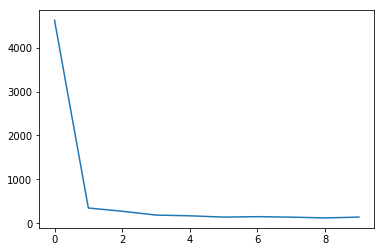

In [43]:
%time plt.plot(range(len(losses)), losses)

In [34]:
W2.value

array([[ 7.84358456],
       [ 7.93765979],
       [13.00523476],
       [ 7.43709401],
       [ 6.58035998],
       [ 8.42113085],
       [ 9.80682925],
       [ 5.61714983],
       [ 5.16177012],
       [ 3.56975653]])

In [36]:
data = load_boston()
X_ = data['data']
y_ = data['target']

In [37]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [38]:
import keras

D:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\

In [41]:
from keras.layers import Dense
from keras.models import Squential

model = Squential()

model.add(Dense(units=30, activateion='sigmoid', input_dim=X_.shape[1]))
model.add(Dense(utis=30, activation='sigmoid', input_dim=30))
model.add(Dense(utis=30, activation='sigmoid', input_dim=30))
model.add(Dense(utis=30, activation='sigmoid', input_dim=30))
model.compile(loss='mse', optimizer='sgd', metrics=['mse'])


ImportError: cannot import name 'Squential'